ImportError: attempted relative import with no known parent package

In [2]:
sz_data = np.load("../data/SZ_E3SM_var1_CR100.npz")["data"]
# sz_data = sz_data.reshape([720, 240, 6, 240]).transpose([0,2,1,3])
sz_data.shape

(720, 6, 240, 240)

In [10]:
sz_data2 = (sz_data-sz_data.min())/sz_data.max()

In [6]:
def random_mask(data, size, n):
    data = np.copy(data)  # Avoid modifying the original data
    *leading_dims, height, width = data.shape
    if size > height or size > width:
        raise ValueError("Mask size exceeds the dimensions of the input data.")

    # Flatten leading dimensions to apply masks uniformly
    reshaped_data = data.reshape(-1, height, width)

    # Apply random masks for each "block" in the flattened data
    for block in reshaped_data:
        rows = np.random.randint(0, height - size + 1, n)
        cols = np.random.randint(0, width - size + 1, n)
        for r, c in zip(rows, cols):
            block[r:r + size, c:c + size] = 0
            
    return reshaped_data.reshape(data.shape)

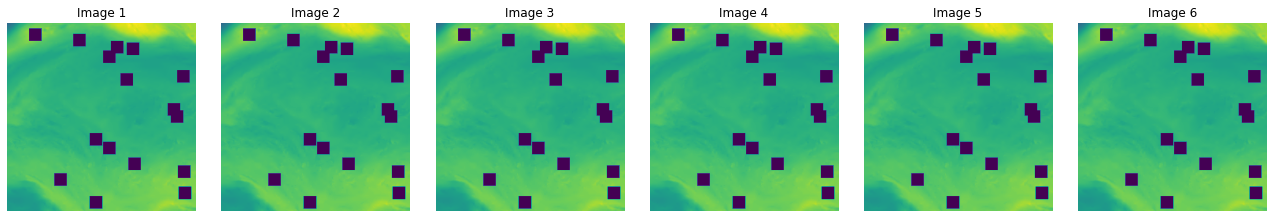

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Generate 6 random images for demonstration
images = random_mask(sz_data2[0,0], 16, 16)
# images = sz_data2[0]
# Create subplots with 1 row and 6 columns
fig, axes = plt.subplots(1, 6, figsize=(18, 3))

# Plot each image in a subplot
for i, ax in enumerate(axes):
    ax.imshow(images, cmap='viridis')  # Use any colormap you prefer
    ax.axis('off')  # Hide axes for a cleaner look
    ax.set_title(f"Image {i+1}")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [2]:
import torch


In [20]:
input_data = torch.randn(10,20,66,45,45)
t_step = 8
n_frame = 8

keep_frames =  input_data.shape[-3] // (t_step * n_frame) * (t_step * n_frame)

input_data = input_data[..., 0:keep_frames, :, :]
shape = input_data.shape

input_data = input_data.reshape(*shape[:-3],  keep_frames // t_step, t_step, *shape[-2:])
input_data = input_data.transpose(-4, -3)
input_data = input_data.reshape(shape)
input_data.shape

torch.Size([10, 20, 64, 45, 45])

In [1]:
import torchvision.transforms as T
import torch
random_crop = T.RandomCrop(20)

random_crop(torch.randn(2,10,10)).shape

ValueError: Required crop size (20, 20) is larger then input image size (10, 10)

In [18]:
a = torch.arange(7)

In [19]:
a[::3], a[::3].shape

(tensor([0, 3, 6]), torch.Size([3]))

In [46]:
def convert_args(args, train=True):
    import yaml

# Load YAML configuration
    with open(args.config, 'r') as file:
        config = yaml.safe_load(file)
    
    if train:
        dnames = args.train_set.split(",")
        var_name = "train_var"
    else:
        dnames = args.test_set.split(",")
        var_name = "test_var"
        
    all_args = []
    
    n_size  = args.input_size
    n_frame = args.n_frame
    
    for dname in dnames:
        print(dname)
        cfg = config[dname]
        if not train:
            n_size = cfg["test_size"]

        train_dict= {"data_path":cfg["path"], "var":cfg[var_name], "input_size": n_size, "n_frame": n_frame}
        if "total_frame" in cfg:
            train_dict.update({"total_frame": cfg["total_frame"]})
            
        all_args.append(train_dict)
    return all_args

import argparse

parser = argparse.ArgumentParser(description="Train a UNet with Channel Attention model.")
parser.add_argument('--batch_size', type=int, default=64, help='Batch size for training')
parser.add_argument('--save_path', type=str, default="./snapshots/E3SM/E3SM_VAE", help='Path to save model and results')
parser.add_argument('--epochs', type=int, default=600, help='Number of epochs for training')
parser.add_argument('--lr', type=float, default=0.001, help='Learning rate')
# parser.add_argument('--lr_milestones', type=int, nargs='+', default=[100, 450], help='Learning rate milestones')
parser.add_argument('--lr_gamma', type=float, default=0.5, help='Learning rate gamma')
parser.add_argument('--loss_beta', type=float, default=20, help='loss beta')
parser.add_argument('--beta_start', type=int, default=300, help='loss beta')
parser.add_argument('--model_dim', type=int, default=16, help='loss beta')
parser.add_argument('--double_rate', type=int, default=32, help='loss beta')

# Datatset
parser.add_argument('--train_set', type=str, default="E3SM,S3D")
parser.add_argument('--test_set', type=str, default="E3SM,S3D")
parser.add_argument('--config', type=str, default="../configs/config.yaml")

parser.add_argument('--input_size', type=int, default=256, help='data size')
parser.add_argument('--n_frame', type=int, default=8, help='data size')

args = parser.parse_args('')            
        

convert_args(args, train=False)

E3SM
S3D


[{'data_path': '/blue/ranka/xiao.li/dataset/climate_dataset/dataset_numpy/08.npz',
  'var': [0],
  'input_size': 256,
  'n_frame': 8},
 {'data_path': '/home/xiao.li/ClimateModeling/shared_fdmodel/s3d/dataset/S3D/1.dataSet/nHep58/input_150to200steps.npy',
  'var': [40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57],
  'input_size': 640,
  'n_frame': 8,
  'total_frame': 48}]

In [35]:
args

Namespace(batch_size=64, save_path='./snapshots/E3SM/E3SM_VAE', epochs=600, lr=0.001, lr_gamma=0.5, loss_beta=20, beta_start=300, model_dim=16, train_set='E3SM,S3D', test_set='E3SM,S3D', double_rate=32, input_size=256, n_frame=1)

In [22]:
shared_folder = "/home/xiao.li/ClimateModeling/shared_fdmodel"
s3d_path = "%s/s3d/dataset/S3D/1.dataSet/nHep58/input_150to200steps.npy"%(shared_folder)

In [23]:
data_args= {"data_path":s3d_path, "var":np.arange(40), "input_size": 256, "n_frame": 8, "total_frame": 48}
dataset = S3D(data_args)

(40, 48, 640, 640)


In [26]:
dataset[10].max(), dataset[10].min()

(tensor(0.2936), tensor(-0.2613))

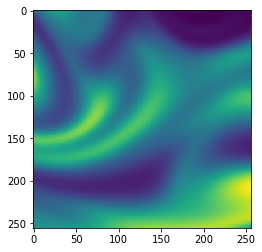

In [22]:
import matplotlib.pyplot as plt

plt.imshow(dataset[1][0])

In [1]:
path = '/home/xiao.li/SciDatasets/JHTDB/channel_psl.h5'

import numpy as np
from jhtdb_dataset import JHTDB

In [27]:
data_args= {"data_path":path, "var":"Pressure_0001", "input_size": 256, "n_frame": 8, "total_frame": 480}
dataset = JHTDB(data_args)

JHTDB Available datasets:
['Pressure_0001', 'xcoor', 'ycoor', 'zcoor']
(480, 512, 512)


In [28]:
dataset[1].min()

tensor(-0.2112)

In [30]:
dataset[0].shape

torch.Size([8, 256, 256])

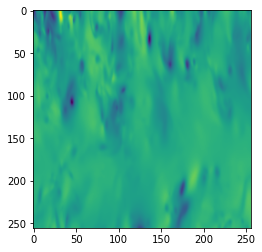

In [29]:
import matplotlib.pyplot as plt

plt.imshow(dataset[1][0])

In [3]:
path = "/blue/ranka/xiao.li/dataset/climate_dataset/dataset_numpy/08.npz"

In [13]:
np.asarray("0 ,1 ,3 ".split(","), dtype = np.int32).tolist()

[0, 1, 3]

In [31]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
from glob import glob
import numpy as np
import json
from tqdm import tqdm
import threading
import torch.nn.functional as F


class Climate240(Dataset):
    def __init__(self, args):
        
        data_path = args["data_path"]
        mode = args["mode"] if "mode" in args else None
        var = args["var"] if "var" in args else [0]
        
        self.input_size = args["input_size"] if "input_size" in args else 240
        self.true_shape = 240
        
        self.dataset_name = "E3SM"
        # path = "/blue/ranka/xiao.li/dataset/climate_dataset/dataset_numpy/08.npz"
        self.e3sm_data = np.load(data_path)["data"][:, np.asarray(var)]
        print(self.e3sm_data.shape)
        
        self.var_mean = np.mean(self.e3sm_data, axis = (0,2,3,4), keepdims = True)
        var_max = np.max(self.e3sm_data, axis = (0,2,3,4), keepdims = True)
        var_min = np.min(self.e3sm_data, axis = (0,2,3,4), keepdims = True)
        self.var_scale = var_max - var_min
                         

        
        self.e3sm_data = (self.e3sm_data - self.var_mean)/self.var_scale

        
        self.e3sm_input = torch.FloatTensor(self.e3sm_data).reshape([-1, 1, 240, 240])
        
        self.pad_left = 0 
        self.pad_right = 0
        
        if self.input_size != 240:
            # Calculate the padding needed on each side
            pad_size = self.input_size - 240
            pad_left = pad_size // 2
            pad_right = pad_size - pad_left  # Ensure total padding equals pad_size

            # Apply padding with zeros around the borders
            # Padding is applied as (left, right, top, bottom)
            self.e3sm_input = F.pad(self.e3sm_input, (pad_left, pad_right, pad_left, pad_right), mode='constant', value=0)
            
            self.pad_left = pad_left 
            self.pad_right = pad_right
        
        self.update_length()
            
    def update_length(self):
        self.dataset_length = self.e3sm_input.shape[0]
        return self.dataset_length            
        
        
    def __len__(self):
        return self.dataset_length

    def __getitem__(self, idx):
        
        return self.e3sm_input[idx]

In [32]:
args= {"data_path":path, "var":[0], "input_size":240}

NameError: name 'path' is not defined

In [33]:
e3sm_set = Climate240(args)

NameError: name 'args' is not defined

In [30]:
(256-240)//2

8

In [31]:
e3sm_set[0].shape

torch.Size([1, 240, 240])

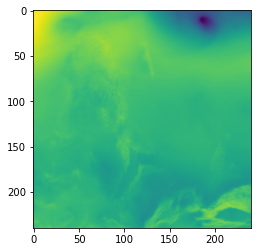

In [33]:
import matplotlib.pyplot as plt
plt.imshow(e3sm_set[0].squeeze().numpy())

In [17]:
e3sm_set[10+720*10].squeeze().numpy().max()

0.012728947

In [14]:
e3sm_set[10+720].squeeze().numpy().min()

-0.6052826

In [30]:
all_max = np.max(e3sm_set.e3sm_data, axis = (3, 4))
all_min = np.min(e3sm_set.e3sm_data, axis = (3, 4))

In [31]:
e3sm_set.e3sm_data.shape

(720, 4, 6, 240, 240)

In [39]:
all_range = np.max(all_max) - np.min(all_min)

1.1824687

In [33]:
all_range.shape

(720, 4, 6)

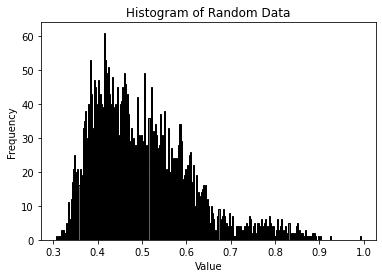

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Generate random data
# data = np.random.randn(1000)

# Create a histogram
plt.hist(all_range[:,3].reshape(-1), bins=300, edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Random Data')

# Display the plot
plt.show()

In [8]:
e3sm_set[0].min()

tensor(-0.2573)

In [71]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
from glob import glob
import numpy as np
import json
from tqdm import tqdm
import threading
import torch.nn.functional as F
import torchvision.transforms as T
from normalization import normalize_data
from basefunc import BaseDataset
import h5py
import gzip

def read_gzip_data(filename, xdim=500, ydim=500, zdim=100):
    with gzip.open(filename, 'rb') as f:
        data = np.frombuffer(f.read(), dtype='>f4')  # '>f4' is big-endian float32
    return data.reshape((zdim, ydim, xdim))

def load_hurricane_dataset(path, variables, z_step=2, remove_gnd = True):
    map_name = {"temperature": "TC", "pressure": "P", "windx":"U", "windy":"V","windz":"w"}
    all_data = []
    
    for var in variables:
        var_data = []
        for i in range(1,48):
            cur_p = path + "/%sf%02d.bin.gz"%(map_name[var],i)
            data = read_gzip_data(cur_p)
            if remove_gnd:
                data = data[36:]
            if z_step!=1:
                data = data[::z_step]
            var_data.append(data)
        var_data = np.stack(var_data)
        all_data.append(var_data)
    all_data = np.stack(all_data)
    return all_data


class Hurricane(BaseDataset):
    def __init__(self, args):
        super().__init__(args)
        self.dataset_name = "JHTDB"
        var  = args["var"]  if "var"  in args else ["temperature","pressure"]
        

        self.data_input = load_hurricane_dataset(self.data_path, var)
        self.true_shape = self.data_input.shape[-1]
        assert(self.true_shape/self.max_downsample>=self.input_size)
        
        
        self.data_input, self.var_mean, self.var_scale = normalize_data(self.data_input, self.norm_type, axis=(1,2,3,4))
        self.data_input = torch.FloatTensor(self.data_input).reshape([-1, self.n_frame, self.true_shape, self.true_shape])
        
        self.visble_length = self.update_length()
      
            
    def update_length(self):
        self.dataset_length = self.data_input.shape[0]
        return self.dataset_length
    
    def __len__(self):
        return self.visble_length

    def __getitem__(self, idx):
        idx = idx % self.dataset_length
        
        data = self.data_input[idx]
        data = self.apply_augments(data)
        data = self.apply_padding_or_crop(data)
        
        return data

In [72]:
args = {"data_path":"/home/xiao.li/SciDatasets/Hurricane/data",
        # "augment_type":{"randsample":2},
        "n_frame":8}
dataset = Hurricane(args)

{} {'data_path': '/home/xiao.li/SciDatasets/Hurricane/data', 'n_frame': 8}


In [30]:
dataset[0].shape

NameError: name 'dataset' is not defined

In [98]:
dataset.data_input.shape

torch.Size([24, 8, 500, 500])

In [74]:
import matplotlib.pyplot as plt

In [84]:
len(dataset)

24

In [29]:
plt.imshow(dataset[0].numpy()[0])

NameError: name 'plt' is not defined

In [38]:
torch.randint(1, 2 + 1, (1,)).item()

1

step 1


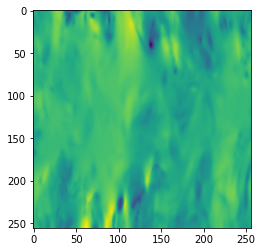

In [39]:
plt.imshow(dataset[0].numpy()[0])

In [41]:
class Climate240(Dataset):
    def __init__(self, args):
        super().__init__(args)
        self.dataset_name = "E3SM"
        
        var = args["var"] if "var" in args else [0]
        n_frame = args["n_frame"] if "n_frame" in args else 1
        
        self.data_input = self.load_e3sm_dataset(self.data_path, var)
        self.true_shape = self.data_input.shape[-1]
        
        assert(self.true_shape/self.max_downsample>self.input_size)
        assert(720%n_frame == 0)
        
        self.data_input, self.var_mean, self.var_scale = normalize_data(self.data_input, self.norm_type, axis=(1,2,3,4))
        self.data_input = torch.FloatTensor(self.data_input).reshape([-1, n_frame, self.true_shape, self.true_shape])
        
        self.visble_length = self.update_length()
    
    def load_e3sm_dataset(self, data_path, var):
        
        print("*************** Loading", self.dataset_name, "***************")
        data = np.load(data_path)["data"][:, np.asarray(var)] # [720, 5, 6, 240, 240]
        data = data.transpose([1,2,0,3,4])
        print("Original Data Shape:", data.shape) #shape (4, 6, 720, 240, 240)
        return data
    
    def update_length(self):
        self.dataset_length = self.data_input.shape[0]
        return self.dataset_length           
        
        
    def __len__(self):
        return self.visble_length

    def __getitem__(self, idx):
        idx = idx % self.dataset_length
        
        data = self.data_input[idx]
        data = self.apply_augments(data)
        data = self.apply_padding_or_crop(data)
        
        return data

In [23]:
def blocking_data(data, block_size):
    if block_size is not None:
        T, H, W = data.shape[-3:]
        b_t, b_h, b_w = block_size
        assert(T%b_t ==0  and H%b_h ==0  and W%b_w ==0)

        n_t = T//b_t
        n_h = H//b_h
        n_w = W//b_w
#                             0   1   2     3    4    5    6
        data = data.reshape(-1, n_t, b_t, n_h, b_h, n_w, b_w)
        data = data.transpose([0,1,3,5,2,4,6]).reshape(-1, b_t, b_h, b_w)
        true_shape = b_w
    else:
        data = data.reshape([-1, n_frame, *data.shape[-2:]])
    return data

In [24]:
import numpy as np

a = np.arange(1000).reshape([10,10,10])

In [25]:
n_frame = 2

In [26]:
b = blocking_data(a, None)

In [27]:
b.shape

(5, 2, 10, 10)

In [28]:
b

array([[[[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9],
         [ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19],
         [ 20,  21,  22,  23,  24,  25,  26,  27,  28,  29],
         [ 30,  31,  32,  33,  34,  35,  36,  37,  38,  39],
         [ 40,  41,  42,  43,  44,  45,  46,  47,  48,  49],
         [ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59],
         [ 60,  61,  62,  63,  64,  65,  66,  67,  68,  69],
         [ 70,  71,  72,  73,  74,  75,  76,  77,  78,  79],
         [ 80,  81,  82,  83,  84,  85,  86,  87,  88,  89],
         [ 90,  91,  92,  93,  94,  95,  96,  97,  98,  99]],

        [[100, 101, 102, 103, 104, 105, 106, 107, 108, 109],
         [110, 111, 112, 113, 114, 115, 116, 117, 118, 119],
         [120, 121, 122, 123, 124, 125, 126, 127, 128, 129],
         [130, 131, 132, 133, 134, 135, 136, 137, 138, 139],
         [140, 141, 142, 143, 144, 145, 146, 147, 148, 149],
         [150, 151, 152, 153, 154, 155, 156, 157, 158, 159],
         [160, 161, 16